In [1]:
import numpy as np

import torch
import torch.utils.data

import datasets
import metaimage
import nnet
import voxel
import display

%load_ext autoreload
%autoreload 2

## Dataset generation

The dataset used for this prototype is a synthetic dataset consisting of masks a 16x16x16 cube centered in a 32x32x32 space, with the masks generated from random angles around the cube.

This is intended as a simple test to identify if a basic, consistent 3D shape can be recovered from a collection of masks.

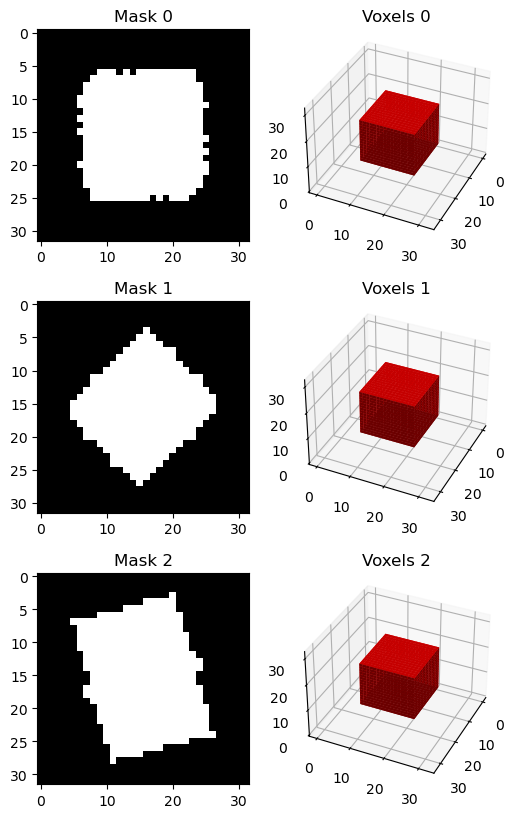

In [7]:
SIDE_RANGE = (16, 16)
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)
BATCH_SIZE = 100

train_auto_dataset = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True)
val_auto_dataset = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100)

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            (f"Mask {i}",train_auto_dataset[i][0]),
            (f"Voxels {i}", train_auto_dataset[i][1][1])
        ] for i in range(3)
    ],
    figsize=(6, 10)
)
display.show()

## GAN

To recover the shape, a GAN is used.

### Generator

The generator is a 3D convolutional network. The latent space is mapped linearly to a 32x4x4x4 tensor. This is then repeatedly upsampled using convolutional layer followed by a strided transpose convolution. This doubles the dimensions and halves the number of channels at each stage, to reach a 4x32x32x32 tensor. Finally, this is passed through a resnet block for refinement, and a final convolutional layer to produce a 1x32x32x32 tensor.

This tensor can then be returned, to provide a voxel representation, or a mask is created from a random angle around the cube to produce a 32x32 mask.

### Discriminator

The discriminator is a 2D resnet. This takes in a 32x32 mask, passes it through a resnet block and downsample using a strided convolution, halving the dimensions and doubling the number of channels at each stage. This is until a 4x4 mask is produced, which is then flattened and passed through a linear layer to produce a single label indicating the probability that the mask is real.

In [18]:
LATENT_SIZE = 12
BASE_CHANNELS = 8
DISCRIMINATOR_CHANNELS = 4
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.2
GENERATOR_DROPOUT = 0.1

discriminator = torch.nn.Sequential(
    nnet.blocks.conv.BasicConvBlock(
        in_channels=1,
        out_channels=DISCRIMINATOR_CHANNELS,
        kernel_size=1,
        activation=ACTIVATION,
    ),
    nnet.blocks.conv.ResizeStack(
        in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1]),
        out_shape=(DISCRIMINATOR_CHANNELS*IMAGE_SIZE[0]//2, 2, 2),
        layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
            stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        layer_factories_per_downsample=0,
    ),
    nnet.blocks.conv.ConvToLinear(
        (DISCRIMINATOR_CHANNELS*IMAGE_SIZE[0]//2, 2, 2),
        out_dim=1,
        activation=torch.nn.Sigmoid,
    )
)

generator = nnet.generators.SolidMaskGenerator(
    torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS*(SPACE_SIZE[0]//2), 2, 2, 2),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS*(SPACE_SIZE[0]//2), 2, 2, 2),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.conv.create_basic_conv_factory(
                use_3d=True,
                dropout=GENERATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            layer_factories_per_downsample=0,
        ),
        nnet.blocks.resnet.create_resnet_block_simple_3d(
            in_channels=BASE_CHANNELS,
            out_channels=BASE_CHANNELS,
            activation=ACTIVATION,
            stochastic_depth_rate=GENERATOR_DROPOUT,
            kernel_size=3,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=1,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        )
    ),
)

gan_trainer = nnet.training.GANTrainer(
    generator,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

In [23]:
model_path = "models/cube_gan"

gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    11,
    path=model_path,
    noise=0.3,
    gen_train_thresh=1.25,
    dis_train_thresh=1.25,
)

Epoch 51/51 | val loss (gen/dis): 0.6784/1.9796 | train loss: 1.30(10)/0.93(4): 100%|██████████| 11/11 [01:04<00:00,  5.86s/it]


Model models/cube_gan_0.pt is loaded from epoch 0 , loss 0.6229
-1.0 1.0
0.6998204
0.0 1.0
Model models/cube_gan_1.pt is loaded from epoch 10 , loss 0.8685
-1.0 1.0
-0.07502884
0.0 1.0
Model models/cube_gan_2.pt is loaded from epoch 20 , loss 1.2490
-1.0 1.0
-0.86317885
0.0 1.0
Model models/cube_gan_3.pt is loaded from epoch 30 , loss 0.6686
-1.0 1.0
-0.76149166
0.0 1.0
Model models/cube_gan_4.pt is loaded from epoch 40 , loss 0.5012
-1.0 1.0
-0.89514136
0.0 1.0
Model models/cube_gan_5.pt is loaded from epoch 50 , loss 0.6784
-1.0 1.0
-0.9597548
0.0 1.0


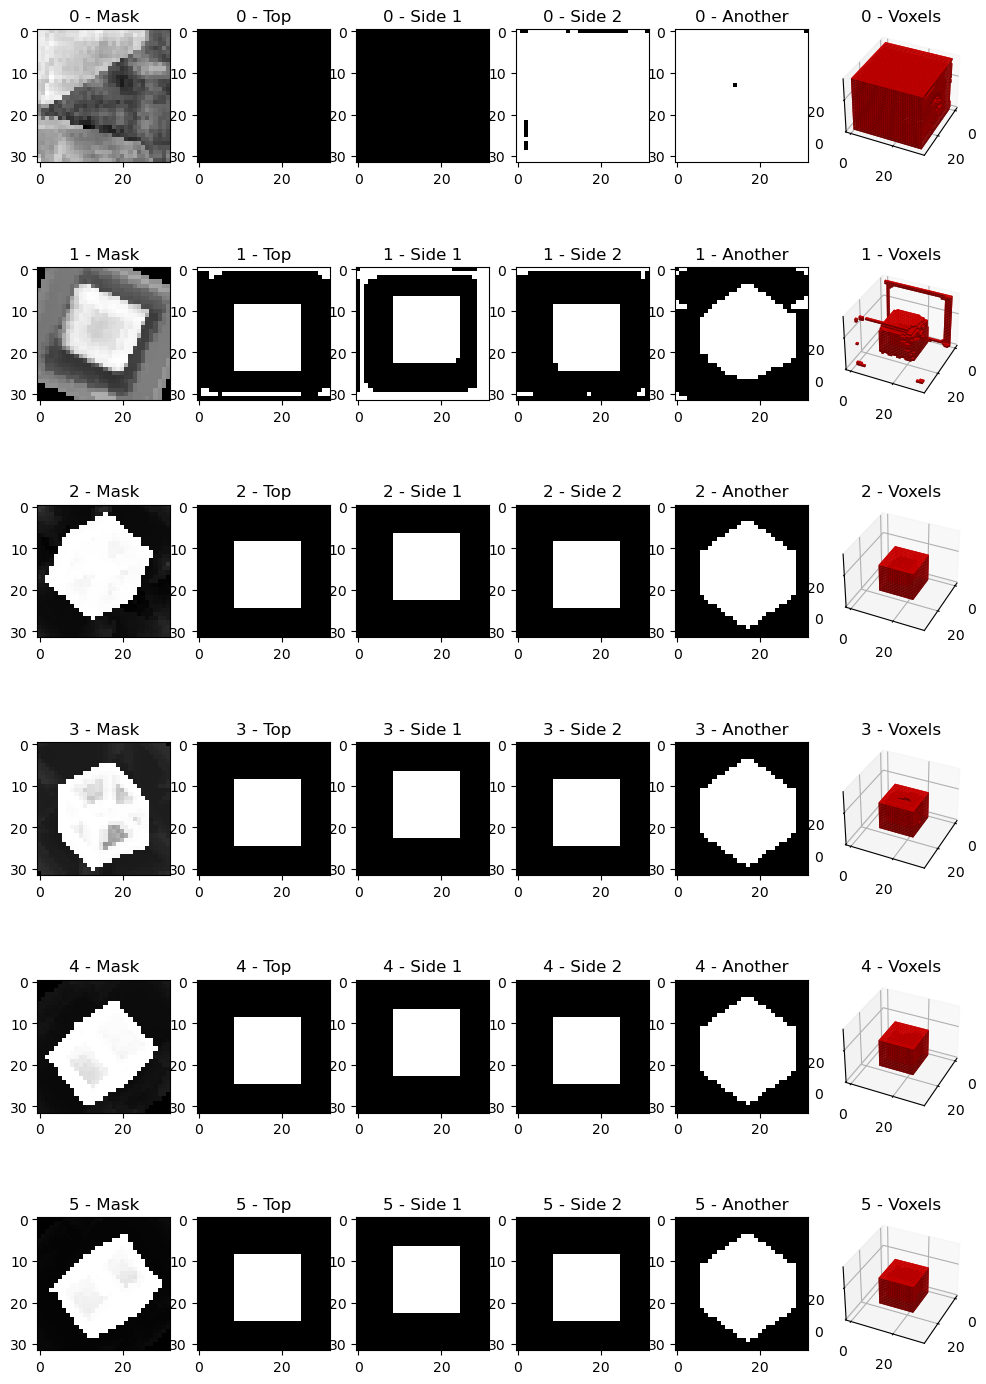

In [28]:
MODELS = (0, 5)

generator.eval()
generator.to("cuda")

N_MODELS = MODELS[1] - MODELS[0] + 1

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for i in range(N_MODELS):
    model_n = MODELS[0]+i
    gan_trainer.load_state(f"{model_path}_{model_n}.pt")

    mask = metaimage.Mask.from_tensor(generator(gen_input)[0], title=f"{model_n} - Mask")
    voxels = voxel.SolidVoxel.from_tensor(generator.voxel_generator(gen_input)[0], title=f"{model_n} - Voxels")
    
    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_mask()),
            (f"{model_n} - Side 1", voxels.create_mask(y_angle=np.pi / 2)),
            (f"{model_n} - Side 2", voxels.create_mask(x_angle=np.pi / 2)),
            (f"{model_n} - Another", voxels.create_mask(np.pi / 4, np.pi / 4)),
            voxels,
        ]
    )
    
display.grid(plot_grid, figsize=(12, 3*N_MODELS))
display.show()

Model models/cube_gan_5.pt is loaded from epoch 50 , loss 0.6784


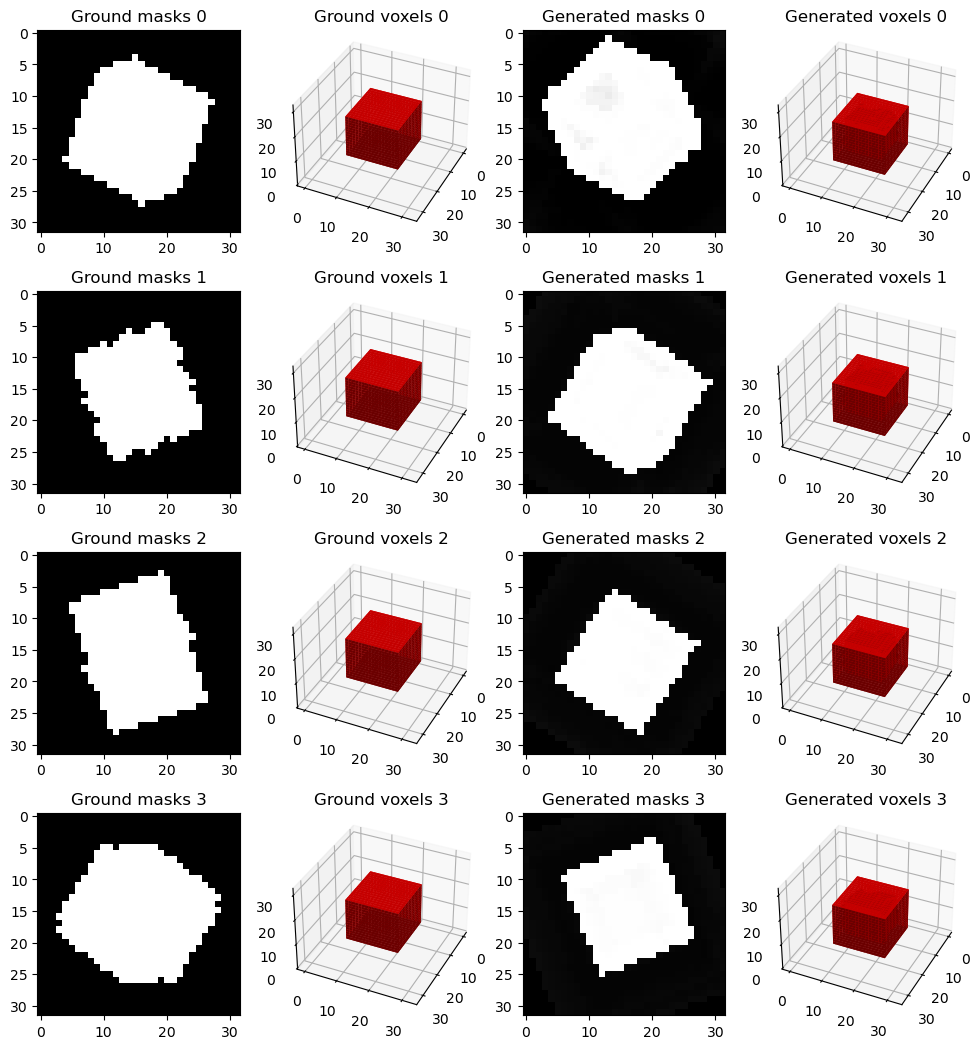

In [27]:
MODEL = 5

gan_trainer.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = generator(gen_input)[:4]
voxels = generator.voxel_generator(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxel.SolidVoxel.from_tensor(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask.from_tensor(masks[i], title=f"Generated masks {i}")
    ground_mask, ground_voxels = train_auto_dataset[i][1]
    ground_mask = metaimage.Mask.from_tensor(ground_mask, title=f"Ground masks {i}")
    ground_voxels = voxel.SolidVoxel.from_array(ground_voxels, title=f"Ground voxels {i}")

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(12, 13))
display.show()